In [1]:
%matplotlib inline
from osgeo import gdal #install gdal before geopandas to avoid running into package conflict
import geopandas as gpd
from datetime import datetime, timedelta
from shapely.geometry import Point
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import pyproj
import rasterio # use pip install, conda fails
from rasterio import mask
import rasterstats as rs
from sklearn.svm import SVR 
from scipy import stats
import rioxarray as rxr
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import multiprocessing
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.metrics import r2_score, mean_squared_error
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
path = r"D:\paper\project\australia\sentinel\clipped"
L2A = gpd.read_file(r"D:\paper\project\australia\ged\canop.shp")

# Retrieve the list of files
alos = [os.path.join(path, item) for item in os.listdir(path) if item.endswith('.tif') and os.path.isfile(os.path.join(path, item))]

# Sort the files based on date
alos.sort(key=lambda x: datetime.strptime(os.path.basename(x).split('_')[1].split('.')[0], '%d%B%Y'))

def process_single_file(file):
    with rasterio.open(file) as src:
        alos_img = src.read(1)
        no_data = src.nodata

        band_name = file.split('_')[0]
        try:
            date_str = os.path.basename(file).split('_')[1].split('.')[0]
            date = datetime.strptime(date_str, '%d%B%Y').date()
        except ValueError:
            print(f"Error extracting date from filename: {file}")
            return None

        alos_stats = rs.zonal_stats(L2A['geometry'],
                                   alos_img,
                                   nodata=no_data,
                                   affine=src.transform,
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="std min mean max median")

        alos_stats_fr = gpd.GeoDataFrame.from_features(alos_stats)
        alos_stats_fr['band'] = band_name
        alos_stats_fr['date'] = date
        alos_stats_fr['image_file'] = os.path.basename(file)

        return alos_stats_fr

# Define the batch size
batch_size = 1

# Process files in batches
batched_files = [alos[i:i+batch_size] for i in range(0, len(alos), batch_size)]
results = []

for batch in batched_files:
    batch_results = [process_single_file(file) for file in batch if process_single_file(file) is not None]
    results.extend(batch_results)

alos_stats_fr = pd.concat(results, ignore_index=True)
print(alos_stats_fr.head())

                         geometry       min       max      mean  std   
0  POINT (242213.163 6281737.954)  0.376617  0.376617  0.376617  0.0  \
1  POINT (243175.702 6280856.708)  1.113397  1.113397  1.113397  0.0   
2  POINT (243301.400 6280742.184)  1.022491  1.022491  1.022491  0.0   
3  POINT (243385.039 6280664.085)  0.840244  0.840244  0.840244  0.0   
4  POINT (243510.424 6280545.787)  1.273713  1.273713  1.273713  0.0   

     median                                            band        date   
0  0.376617  D:\paper\project\australia\sentinel\clipped\VH  2019-02-01  \
1  1.113397  D:\paper\project\australia\sentinel\clipped\VH  2019-02-01   
2  1.022491  D:\paper\project\australia\sentinel\clipped\VH  2019-02-01   
3  0.840244  D:\paper\project\australia\sentinel\clipped\VH  2019-02-01   
4  1.273713  D:\paper\project\australia\sentinel\clipped\VH  2019-02-01   

              image_file  
0  VH_01February2019.tif  
1  VH_01February2019.tif  
2  VH_01February2019.tif  
3  VH_01

In [3]:
# Perform spatial join
merged_df = gpd.sjoin(L2A, alos_stats_fr, how='left', predicate='intersects')

# Print the merged dataframe
print(merged_df.head())

    Longitude   Latitude      rh_98                       datetime   
0  150.222772 -33.572935   2.470000  2021-05-12 23:08:20.248425603  \
1  150.232878 -33.581106  27.590000  2021-05-12 23:08:20.438497603   
2  150.234198 -33.582168  22.379999  2021-05-12 23:08:20.463289604   
3  150.235075 -33.582892  24.590000  2021-05-12 23:08:20.479817599   
4  150.236391 -33.583988  30.660000  2021-05-12 23:08:20.504615605   

                         geometry  index_right       min       max      mean   
0  POINT (242213.163 6281737.954)            0  0.376617  0.376617  0.376617  \
1  POINT (243175.702 6280856.708)            1  1.113397  1.113397  1.113397   
2  POINT (243301.400 6280742.184)            2  1.022491  1.022491  1.022491   
3  POINT (243385.039 6280664.085)            3  0.840244  0.840244  0.840244   
4  POINT (243510.424 6280545.787)            4  1.273713  1.273713  1.273713   

   std    median                                            band        date   
0  0.0  0.376617  

C:\Users\Khamila CN\AppData\Local\Temp\ipykernel_13464\1432414221.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["WGS_1984_UTM_Zone_56S",GEOGCS["WGS 84",DAT ...
Right CRS: None

  merged_df = gpd.sjoin(L2A, alos_stats_fr, how='left', predicate='intersects')


In [4]:
X = merged_df['max']
y = merged_df['rh_98']

Epoch 1/100

11/11 [==============================] - 1s 3ms/step - loss: 626.9011
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 615.3630
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 599.5280
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 577.2896
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 545.3989
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 499.1380
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 433.6437
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 353.5905
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 265.3629
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 190.7973
Epoch 11/100
11/11 [==============================] - 0s 5ms/step - loss: 147.7952
Epoch 12/100
11/11 [==============================] - 0s 4ms/step - loss: 130.8778
Epoch 13/100

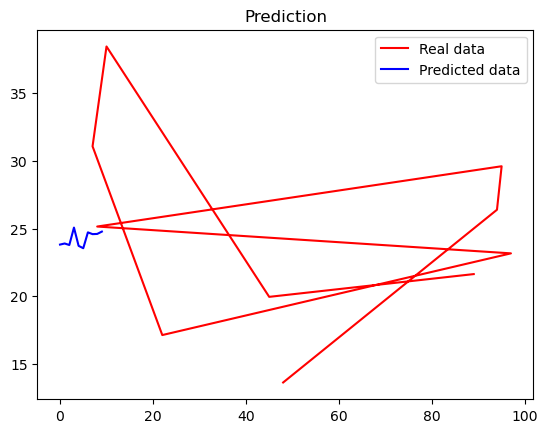

In [36]:
# split the data into train test
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.08, random_state = 0)

X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 1))

# Adding the second hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size=10, epochs=100)

# Reshape the test data
X_test_reshaped = np.reshape(X_test, (-1, 1))

# Make predictions
y_pred = model.predict(X_test_reshaped)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [38]:
y_pred = y_pred.flatten()

# R-squared (R2) Score
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2) Score: {r2}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

R-squared (R2) Score: 0.045656594328344124
Root Mean Squared Error (RMSE): 6.697454252946271
Mean Squared Error (MSE): 44.85589347030809
